In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import time

In [2]:
# read metadata
path = "/media/yesindeed/WD5T/data/Harvard-FairVLMed10k"

demo_data = pd.read_csv(os.path.join(path, "ReadMe", "data_summary.csv"))
demo_data

,filename,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use
0,data_00001.npz,56.56,female,black,non-hispanic,english,single,ms. PERSON is a 56 yo woman presenting to esta...,The 56 y/o female patient has optic nerve head...,yes,training
1,data_00002.npz,53.91,female,white,non-hispanic,english,single,referred for evaluation of narrow angles ou #p...,Patient was referred for narrow angle evaluati...,yes,training
2,data_00003.npz,46.30,female,white,non-hispanic,english,single,1. left upper lid ptosis: occurred after botox...,"Patient experienced ptosis, ear and eye pain, ...",no,training
3,data_00004.npz,66.52,male,white,non-hispanic,english,single,right plano +0.50 082 left LOCATION -0.50 83 a...,The patient has primary open angle glaucoma - ...,yes,training
4,data_00005.npz,82.52,female,black,non-hispanic,english,divorced,in step. os with nonspecific peripheral defect...,The patient has nonspecific peripheral defects...,yes,training
...,...,...,...,...,...,...,...,...,...,...,...
9995,data_09996.npz,84.71,female,white,non-hispanic,english,married or partnered,"than or equal to 17 mmhg, right eye. -goal int...","Patient has glaucoma, with right eye (OD) intr...",yes,test
9996,data_09997.npz,40.32,male,white,non-hispanic,english,married or partnered,40 y/o male who presents DATE_TIME for iop che...,"40 y/o male, suspect for glaucoma due to enlar...",no,test
9997,data_09998.npz,57.58,male,black,non-hispanic,english,married or partnered,"57 URLleh/o glaucoma suspect, presents for gla...",57-year-old patient suspected of glaucoma unde...,no,test
9998,data_09999.npz,73.03,female,white,non-hispanic,english,married or partnered,imp: doing well with pciol ou (toric os) pvd o...,"Patient has pciol ou, toric os, pvd ou, and cu...",no,test


In [3]:
# demo_data = demo_data.assign(path=lambda x: f"{str(x['use']).capitalize()}/slo_fundus_{str(x['filename'])[5:10]}.jpg")
demo_data["path"] = demo_data.apply(
    lambda x: f"{str(x['use']).capitalize()}/slo_fundus_{str(x['filename'])[5:10]}.jpg", axis=1
)
demo_data

,filename,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use,path
0,data_00001.npz,56.56,female,black,non-hispanic,english,single,ms. PERSON is a 56 yo woman presenting to esta...,The 56 y/o female patient has optic nerve head...,yes,training,Training/slo_fundus_00001.jpg
1,data_00002.npz,53.91,female,white,non-hispanic,english,single,referred for evaluation of narrow angles ou #p...,Patient was referred for narrow angle evaluati...,yes,training,Training/slo_fundus_00002.jpg
2,data_00003.npz,46.30,female,white,non-hispanic,english,single,1. left upper lid ptosis: occurred after botox...,"Patient experienced ptosis, ear and eye pain, ...",no,training,Training/slo_fundus_00003.jpg
3,data_00004.npz,66.52,male,white,non-hispanic,english,single,right plano +0.50 082 left LOCATION -0.50 83 a...,The patient has primary open angle glaucoma - ...,yes,training,Training/slo_fundus_00004.jpg
4,data_00005.npz,82.52,female,black,non-hispanic,english,divorced,in step. os with nonspecific peripheral defect...,The patient has nonspecific peripheral defects...,yes,training,Training/slo_fundus_00005.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,data_09996.npz,84.71,female,white,non-hispanic,english,married or partnered,"than or equal to 17 mmhg, right eye. -goal int...","Patient has glaucoma, with right eye (OD) intr...",yes,test,Test/slo_fundus_09996.jpg
9996,data_09997.npz,40.32,male,white,non-hispanic,english,married or partnered,40 y/o male who presents DATE_TIME for iop che...,"40 y/o male, suspect for glaucoma due to enlar...",no,test,Test/slo_fundus_09997.jpg
9997,data_09998.npz,57.58,male,black,non-hispanic,english,married or partnered,"57 URLleh/o glaucoma suspect, presents for gla...",57-year-old patient suspected of glaucoma unde...,no,test,Test/slo_fundus_09998.jpg
9998,data_09999.npz,73.03,female,white,non-hispanic,english,married or partnered,imp: doing well with pciol ou (toric os) pvd o...,"Patient has pciol ou, toric os, pvd ou, and cu...",no,test,Test/slo_fundus_09999.jpg


In [4]:
sub_df = demo_data.loc[demo_data["use"] == "test"]

len(sub_df.loc[sub_df["gender"] == "male"])

904

In [5]:
demo_data["gender"].value_counts()

gender
female    5631
male      4369
Name: count, dtype: int64

In [6]:
demo_data["language"].value_counts()

language
english    9250
unknown     498
spanish     176
other        76
Name: count, dtype: int64

In [38]:
def split_82(all_meta, max_test_size_per_group):
    males = all_meta[all_meta["gender"] == "male"]
    females = all_meta[all_meta["gender"] == "female"]

    males_train, males_test = train_test_split(
        np.unique(males["filename"]), test_size=max_test_size_per_group, random_state=0
    )
    females_train, females_test = train_test_split(
        np.unique(females["filename"]), test_size=max_test_size_per_group, random_state=0
    )

    sub_train = np.concatenate([males_train, females_train])
    sub_test = np.concatenate([males_test, females_test])

    train_meta = all_meta[all_meta["filename"].isin(sub_train)]
    test_meta = all_meta[all_meta["filename"].isin(sub_test)]

    return train_meta, test_meta


unique_males = demo_data[demo_data["gender"] == "male"]["filename"].nunique()
unique_females = demo_data[demo_data["gender"]
                           == "female"]["filename"].nunique()
max_test_size_per_group = min(
    int(0.2 * unique_females), int(0.2 * unique_males))

# sub_train_meta, sub_test_meta = split_82(demo_data, max_test_size_per_group)


sub_train, sub_test = split_82(demo_data, max_test_size_per_group)

sub_train.to_csv(os.path.join(path, "train.csv"), index=False)
sub_test.to_csv(os.path.join(path, "test.csv"), index=False)

In [4]:
# age

df_test = pd.read_csv(os.path.join(path, "test.csv"))

df_test = df_test[~df_test["age"].isnull()]

df_test["age_binary"] = df_test["age"].values.astype("float")
df_test["age_binary"] = np.where(df_test["age_binary"].between(-1, 60), 0, df_test["age_binary"])
df_test["age_binary"] = np.where(df_test["age_binary"] >= 60, 1, df_test["age_binary"])

class_counts = df_test["age_binary"].value_counts()
print(class_counts)
min_count = class_counts.min()
balanced_test_meta = df_test.groupby("age_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


balanced_test_meta.to_csv(os.path.join(path, "test_age.csv"), index=False)

balanced_test_meta["age_binary"].value_counts()

age_binary
1.0    1058
0.0     688
Name: count, dtype: int64


/tmp/ipykernel_1688961/268983679.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_test_meta = df_test.groupby("age_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


age_binary
0.0    688
1.0    688
Name: count, dtype: int64

In [3]:
# race

df_test = pd.read_csv(os.path.join(path, "test.csv"))

df_test["race_binary"] = df_test["race"].apply(lambda x: "white" if "white" in x else "non-white")

print(df_test["race_binary"].value_counts(dropna=False))

class_counts = df_test["race_binary"].value_counts()
print(class_counts)
min_count = class_counts.min()
balanced_test_meta = df_test.groupby("race_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


balanced_test_meta.to_csv(os.path.join(path, "test_race.csv"), index=False)
balanced_test_meta["race_binary"].value_counts()

race_binary
white        1353
non-white     393
Name: count, dtype: int64
race_binary
white        1353
non-white     393
Name: count, dtype: int64


/tmp/ipykernel_1688961/3304072882.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_test_meta = df_test.groupby("race_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


race_binary
non-white    393
white        393
Name: count, dtype: int64

In [9]:
# language
df_test = pd.read_csv(os.path.join(path, "test.csv"))

df_test["language_binary"] = df_test["language"].apply(lambda x: "english" if "english" in x else "non-english")
df_test["language_value"] = df_test["language"].apply(lambda x: 0 if "english" in x else 1)

print(df_test["language_binary"].value_counts(dropna=False))

class_counts = df_test["language_binary"].value_counts()
print(class_counts)
min_count = class_counts.min()
balanced_test_meta = df_test.groupby("language_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


balanced_test_meta.to_csv(os.path.join(path, "test_language.csv"), index=False)
balanced_test_meta["language_binary"].value_counts()

language_binary
english        1619
non-english     127
Name: count, dtype: int64
language_binary
english        1619
non-english     127
Name: count, dtype: int64


/tmp/ipykernel_8973/242945893.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_test_meta = df_test.groupby("language_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


language_binary
english        127
non-english    127
Name: count, dtype: int64

86
0


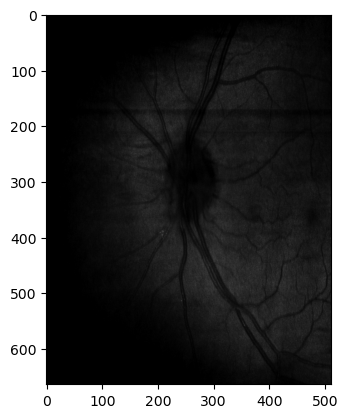

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

# you can have a look of some examples here
npz = np.load(
    "/media/yesindeed/WD5T/data/Harvard-FairVLMed10k/Training/data_00001.npz")
img = npz["slo_fundus"]

print(img.max())
print(img.min())

img = Image.fromarray(img).convert("RGB")

plt.imshow(img, "gray")

86
(664, 512, 3)


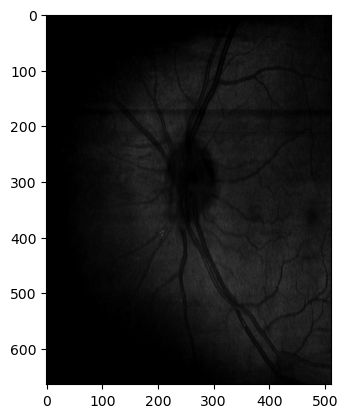

In [20]:
img = Image.open("/media/yesindeed/WD5T/data/Harvard-FairVLMed10k/Training/slo_fundus_00001.jpg")
plt.imshow(img)

img = np.array(img)
print(img.max())
print(img.shape)